-6768.581351041952
-6768.581351039909
1500.9951096462555
-3019.8696380262127


C:\Users\spice\AppData\Local\Temp\ipykernel_34916\1338993233.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


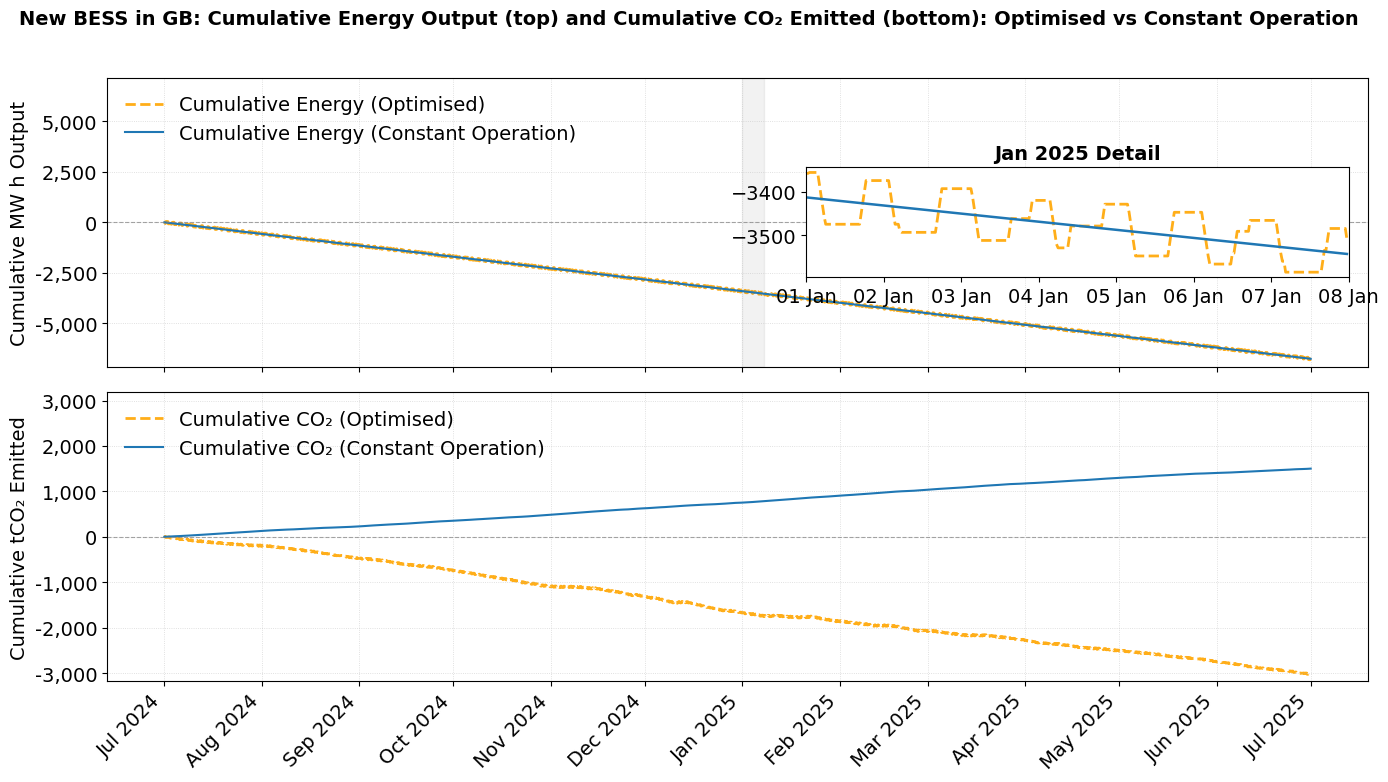

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# === GLOBAL FONT SIZES (min 14) ===
plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})

# === CONFIG ===
data_path = Path(r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet_optimised_LP (MEF_GB).csv")
co2_units = "t"  # "t" for tonnes, "kg" for kilograms

# Inset config (you can tweak these)
inset_loc = "right"  # 'upper left' | 'upper right' | 'lower left' | 'lower right' | 'center left' | 'center right' | etc.
inset_size = ("43%", "38%")  # (width, height)
inset_borderpad = 1.0

# === LOAD ===
df = pd.read_csv(data_path)
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], dayfirst=True, errors='coerce')
df['SettlementPeriod'] = pd.to_numeric(df['SettlementPeriod'], errors='coerce').fillna(0).astype(int)
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.dropna(subset=['datetime']).sort_values('datetime')

# === ENERGY USED PER PERIOD ===
energy_used_orig = df['BatteryChargeMWh'].fillna(0) + df['BatteryDischargeMWh'].fillna(0)
energy_used_opt  = df['OptimisedChargeMWh'].fillna(0) + df['OptimisedDischargeMWh'].fillna(0)

# Cumulative energy
cum_energy_orig = energy_used_orig.cumsum()
cum_energy_opt  = energy_used_opt.cumsum()
print(cum_energy_orig.iloc[-1])
print(cum_energy_opt.iloc[-1])

# === CO₂ PER PERIOD ===
emf = pd.to_numeric(df['EmissionFactor'], errors='coerce').fillna(0)
co2_orig = emf * energy_used_orig
co2_opt  = emf * energy_used_opt

# Convert units and flip sign (plot less CO₂ upward)
if co2_units.lower() == "t":
    co2_orig = co2_orig / 1000.0
    co2_opt  = co2_opt  / 1000.0
co2_orig *= -1
co2_opt  *= -1

# Cumulative CO₂
cum_co2_orig = co2_orig.cumsum()
cum_co2_opt  = co2_opt.cumsum()
print(cum_co2_orig.iloc[-1])
print(cum_co2_opt.iloc[-1])

# === Symmetric limits about zero for each subplot ===
energy_max = pd.concat([cum_energy_orig, cum_energy_opt]).abs().max()
co2_max    = pd.concat([cum_co2_orig,   cum_co2_opt]).abs().max()
energy_lim = (-energy_max*1.05, energy_max*1.05) if energy_max > 0 else (-1, 1)
co2_lim    = (-co2_max*1.05,    co2_max*1.05)     if co2_max > 0   else (-1, 1)

# === Pick a 1-week January window (fallback to first 7 days available) ===
jan_mask = df['datetime'].dt.month == 1
if jan_mask.any():
    start_week = df.loc[jan_mask, 'datetime'].min().normalize()
else:
    start_week = df['datetime'].min().normalize()
end_week = start_week + pd.Timedelta(days=7)
win_mask = (df['datetime'] >= start_week) & (df['datetime'] < end_week)

# === PLOT ===
fig, (ax_energy, ax_co2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# --- Top: Cumulative Energy (Optimised first, then Constant Operation) ---
ax_energy.plot(df['datetime'], cum_energy_opt,  label='Cumulative Energy (Optimised)', color='orange', linewidth=2, linestyle='--', alpha=0.9, zorder=1)
ax_energy.plot(df['datetime'], cum_energy_orig, label='Cumulative Energy (Constant Operation)', linewidth=1.5, zorder=2)
ax_energy.set_ylabel("Cumulative MW h Output", fontsize=14)
ax_energy.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax_energy.set_ylim(*energy_lim)
ax_energy.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.7)
ax_energy.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.5)
ax_energy.legend(loc='upper left', frameon=False, fontsize=14)
ax_energy.tick_params(axis='both', labelsize=14)

# --- Inset on the energy chart: zoom into the selected week ---
in_ax = inset_axes(ax_energy, width=inset_size[0], height=inset_size[1], loc=inset_loc, borderpad=inset_borderpad)
in_ax.set_title("Jan 2025 Detail", fontsize=14, weight='bold')
# plot Optimised first, then Constant Operation on top
in_ax.plot(df.loc[win_mask, 'datetime'], cum_energy_opt.loc[win_mask],  color='orange', linewidth=2, linestyle='--', alpha=0.9, zorder=1)
in_ax.plot(df.loc[win_mask, 'datetime'], cum_energy_orig.loc[win_mask], linewidth=1.8, zorder=2)
# tight y-lims around the window (with a touch of padding)
ymin = pd.concat([cum_energy_opt.loc[win_mask], cum_energy_orig.loc[win_mask]]).min()
ymax = pd.concat([cum_energy_opt.loc[win_mask], cum_energy_orig.loc[win_mask]]).max()
pad = (ymax - ymin) * 0.05 if ymax > ymin else 1.0
in_ax.set_xlim(start_week, end_week)
in_ax.set_ylim(ymin - pad, ymax + pad)
in_ax.axhline(0, color='gray', linewidth=0.6, linestyle='--', alpha=0.6)
in_ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
in_ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
in_ax.tick_params(axis='both', labelsize=14)

# Optional: highlight the zoomed window on the main energy plot
ax_energy.axvspan(start_week, end_week, color='gray', alpha=0.1)

# --- Bottom: Cumulative CO₂ (Optimised first, then Constant Operation) ---
ax_co2.plot(df['datetime'], cum_co2_opt,  label=f'Cumulative CO₂ (Optimised)', color='orange', linewidth=2, linestyle='--', alpha=0.9, zorder=1)
ax_co2.plot(df['datetime'], cum_co2_orig, label=f'Cumulative CO₂ (Constant Operation)', linewidth=1.5, zorder=2)
ax_co2.set_ylabel(f'Cumulative {"t" if co2_units=="t" else "kg"}CO₂ Emitted', fontsize=14)
ax_co2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax_co2.set_ylim(*co2_lim)
ax_co2.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.7)
ax_co2.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.5)
ax_co2.legend(loc='upper left', frameon=False, fontsize=14)
ax_co2.tick_params(axis='both', labelsize=14)

# X-axis formatting (shared)
ax_co2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax_co2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax_co2.get_xticklabels(), rotation=45, ha='right', fontsize=14)

# Title + layout
plt.suptitle('New BESS in GB: Cumulative Energy Output (top) and Cumulative CO₂ Emitted (bottom): Optimised vs Constant Operation', fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



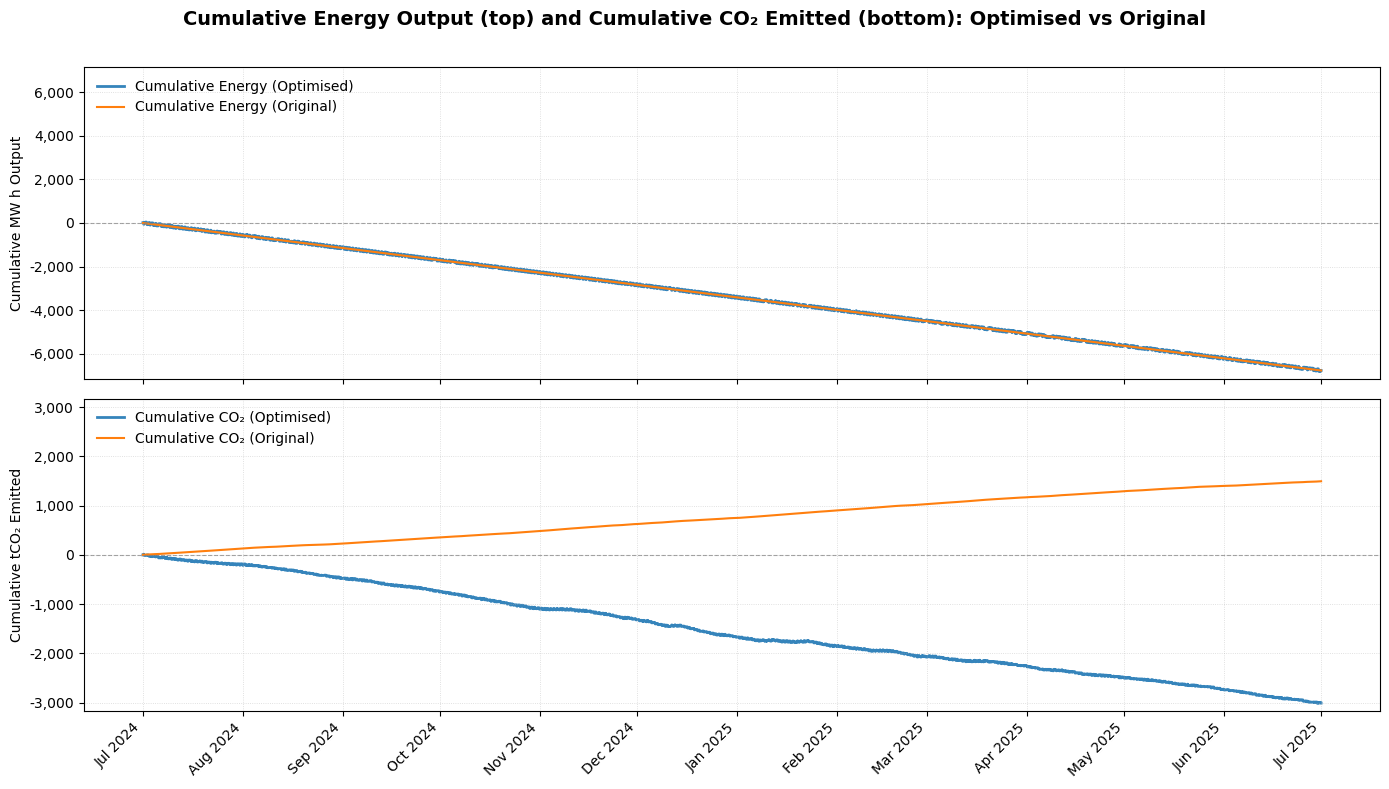

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from pathlib import Path

# === CONFIG ===
data_path = Path(r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet_optimised_LP (MEF_GB).csv")
co2_units = "t"  # "t" for tonnes, "kg" for kilograms

# === LOAD ===
df = pd.read_csv(data_path)
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], dayfirst=True, errors='coerce')
df['SettlementPeriod'] = pd.to_numeric(df['SettlementPeriod'], errors='coerce').fillna(0).astype(int)
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.dropna(subset=['datetime']).sort_values('datetime')

# === ENERGY USED PER PERIOD ===
energy_used_orig = df['BatteryChargeMWh'].fillna(0) + df['BatteryDischargeMWh'].fillna(0)
energy_used_opt  = df['OptimisedChargeMWh'].fillna(0) + df['OptimisedDischargeMWh'].fillna(0)

# Cumulative energy
cum_energy_orig = energy_used_orig.cumsum()
cum_energy_opt  = energy_used_opt.cumsum()

# === CO₂ PER PERIOD ===
emf = pd.to_numeric(df['EmissionFactor'], errors='coerce').fillna(0)
co2_orig = emf * energy_used_orig
co2_opt  = emf * energy_used_opt

# Convert units and flip sign (so lower CO₂ plots upward if you prefer that convention)
if co2_units.lower() == "t":
    co2_orig = co2_orig / 1000.0
    co2_opt  = co2_opt  / 1000.0
co2_orig *= -1
co2_opt  *= -1

# Cumulative CO₂
cum_co2_orig = co2_orig.cumsum()
cum_co2_opt  = co2_opt.cumsum()

# === Symmetric limits about zero for each subplot (helps visual alignment around 0) ===
energy_max = pd.concat([cum_energy_orig, cum_energy_opt]).abs().max()
co2_max    = pd.concat([cum_co2_orig,   cum_co2_opt]).abs().max()
energy_lim = (-energy_max*1.05, energy_max*1.05) if energy_max > 0 else (-1, 1)
co2_lim    = (-co2_max*1.05,    co2_max*1.05)     if co2_max > 0   else (-1, 1)

# === PLOT ===
fig, (ax_energy, ax_co2) = plt.subplots(nrows=2, ncols=1, figsize=(14, 8), sharex=True)

# --- Top: Cumulative Energy (plot Optimised first, then Original on top) ---
ax_energy.plot(df['datetime'], cum_energy_opt,  label='Cumulative Energy (Optimised)', linewidth=2, alpha=0.9, zorder=1)
ax_energy.plot(df['datetime'], cum_energy_orig, label='Cumulative Energy (Original)',  linewidth=1.5, zorder=2)
ax_energy.set_ylabel("Cumulative MW h Output")
ax_energy.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax_energy.set_ylim(*energy_lim)
ax_energy.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.7)
ax_energy.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.5)
ax_energy.legend(loc='upper left', frameon=False)

# --- Bottom: Cumulative CO₂ (Optimised first, then Original on top) ---
ax_co2.plot(df['datetime'], cum_co2_opt,  label=f'Cumulative CO₂ (Optimised)', linewidth=2, alpha=0.9, zorder=1)
ax_co2.plot(df['datetime'], cum_co2_orig, label=f'Cumulative CO₂ (Original)',  linewidth=1.5, zorder=2)
ax_co2.set_ylabel(f'Cumulative { "t" if co2_units=="t" else "kg" }CO₂ Emitted')
ax_co2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax_co2.set_ylim(*co2_lim)
ax_co2.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.7)
ax_co2.grid(True, which='major', linestyle=':', linewidth=0.6, alpha=0.5)
ax_co2.legend(loc='upper left', frameon=False)

# X-axis formatting
ax_co2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax_co2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax_co2.get_xticklabels(), rotation=45, ha='right', fontsize=10)

plt.suptitle('Cumulative Energy Output (top) and Cumulative CO₂ Emitted (bottom): Optimised vs Original', fontsize=14, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


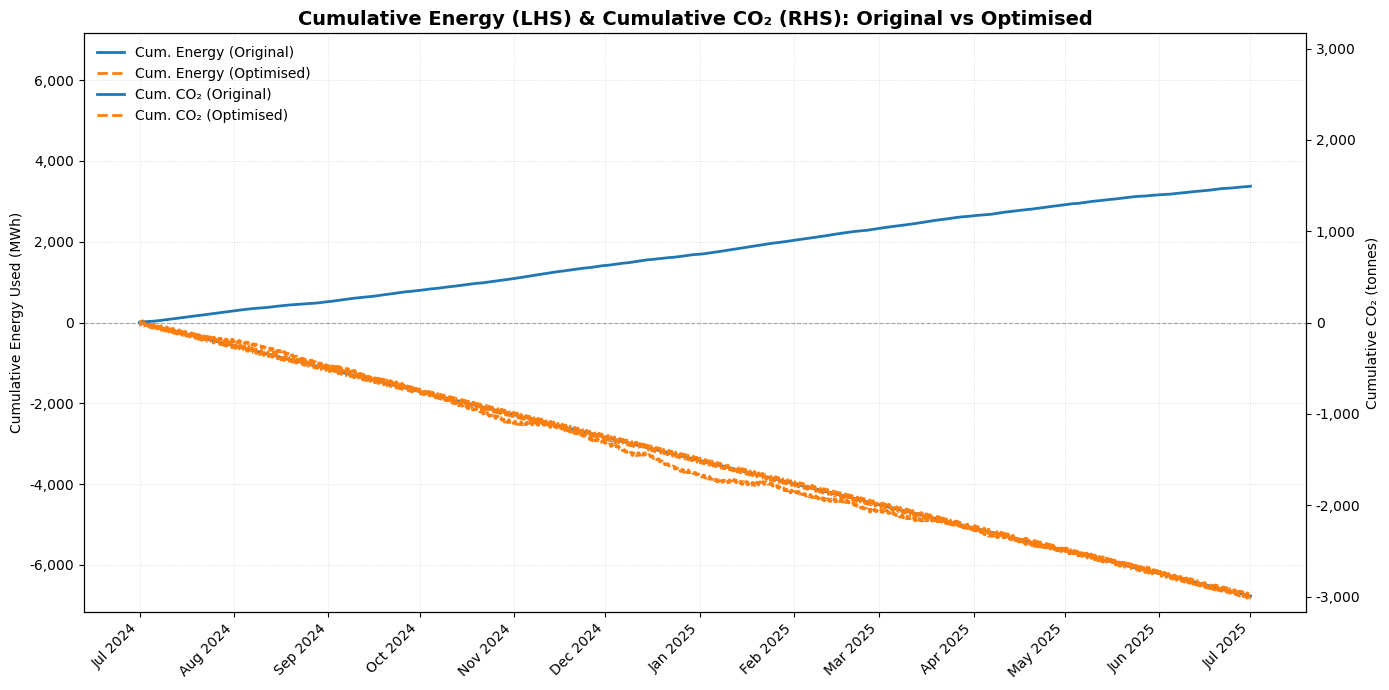

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from pathlib import Path

# === CONFIG ===
data_path = Path(r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet_optimised_LP (MEF_GB).csv")
co2_units = "t"  # "t" for tonnes, "kg" for kilograms

# === LOAD ===
df = pd.read_csv(data_path)
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], dayfirst=True, errors='coerce')
df['SettlementPeriod'] = pd.to_numeric(df['SettlementPeriod'], errors='coerce').fillna(0).astype(int)
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.dropna(subset=['datetime']).sort_values('datetime')

# === ENERGY USED PER PERIOD ===
energy_used_orig = df['BatteryChargeMWh'].fillna(0) + df['BatteryDischargeMWh'].fillna(0)
energy_used_opt  = df['OptimisedChargeMWh'].fillna(0) + df['OptimisedDischargeMWh'].fillna(0)

# Cumulative energy (LHS)
cum_energy_orig = energy_used_orig.cumsum()
cum_energy_opt  = energy_used_opt.cumsum()

# === CO₂ PER PERIOD ===
emf = pd.to_numeric(df['EmissionFactor'], errors='coerce').fillna(0)
co2_orig = emf * energy_used_orig
co2_opt  = emf * energy_used_opt

# Convert to tonnes if requested
if co2_units.lower() == "t":
    co2_orig = co2_orig / 1000.0
    co2_opt  = co2_opt  / 1000.0

# Flip sign (plot CO₂ as negative burden if EF positive)
co2_orig *= -1
co2_opt  *= -1

# Cumulative CO₂ (RHS)
cum_co2_orig = co2_orig.cumsum()
cum_co2_opt  = co2_opt.cumsum()

# === Compute symmetric limits about zero for perfect zero alignment ===
# Left axis: use both energy series
energy_combined = pd.concat([cum_energy_orig, cum_energy_opt])
energy_max = energy_combined.abs().max()
energy_lim = (-energy_max, energy_max)

# Right axis: use both CO2 series
co2_combined = pd.concat([cum_co2_orig, cum_co2_opt])
co2_max = co2_combined.abs().max()
co2_lim = (-co2_max, co2_max)

# === PLOT ===
fig, ax_left = plt.subplots(figsize=(14, 7))

# Left axis (cumulative energy)
line1, = ax_left.plot(df['datetime'], cum_energy_orig, label='Cum. Energy (Original)', linewidth=2)
line2, = ax_left.plot(df['datetime'], cum_energy_opt,  label='Cum. Energy (Optimised)', linewidth=2, linestyle='--')
ax_left.set_ylabel("Cumulative Energy Used (MWh)")
ax_left.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax_left.set_ylim(energy_lim[0]*1.05, energy_lim[1]*1.05)
ax_left.grid(True, which='major', axis='both', linestyle=':', linewidth=0.6, alpha=0.5)

# Right axis (cumulative CO2)
ax_right = ax_left.twinx()
line3, = ax_right.plot(df['datetime'], cum_co2_orig, label=f'Cum. CO₂ (Original)', linewidth=2)
line4, = ax_right.plot(df['datetime'], cum_co2_opt,  label=f'Cum. CO₂ (Optimised)', linewidth=2, linestyle='--')
ax_right.set_ylabel(f'Cumulative CO₂ ({ "tonnes" if co2_units=="t" else "kg" })')
ax_right.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax_right.set_ylim(co2_lim[0]*1.05, co2_lim[1]*1.05)

# Zero line (aligns across both axes because both are symmetric about 0)
ax_left.axhline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.7)

# X-axis formatting
ax_left.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax_left.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax_left.get_xticklabels(), rotation=45, ha='right', fontsize=10)

# Title & legend
plt.title('Cumulative Energy (LHS) & Cumulative CO₂ (RHS): Original vs Optimised', fontsize=14, weight='bold')
lines = [line1, line2, line3, line4]
labels = [ln.get_label() for ln in lines]
ax_left.legend(lines, labels, loc='upper left', fontsize=10, frameon=False)

plt.tight_layout()
plt.show()


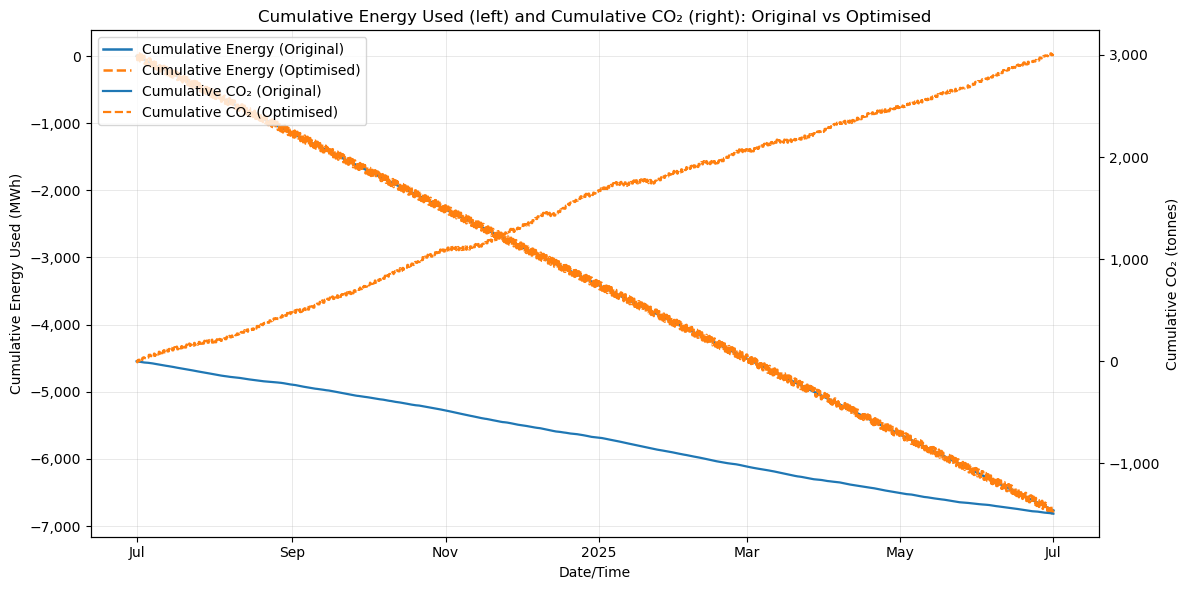

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from pathlib import Path

# === CONFIG ===
# Point this to the CSV you saved from the optimiser:
data_path = Path(r"C:\Users\spice\Dropbox\Documents\Imperial 2024.2025\MECH70038 - Research Projects\_My Thesis\Data\Battery Emissions Optimisation Sheet_optimised_LP (MEF_GB).csv")

# CO2 units: "t" for tonnes, "kg" for kilograms
co2_units = "t"

# === LOAD ===
df = pd.read_csv(data_path)

# Build datetime from SettlementDate + SettlementPeriod
df['SettlementDate'] = pd.to_datetime(df['SettlementDate'], dayfirst=True, errors='coerce')
df['SettlementPeriod'] = pd.to_numeric(df['SettlementPeriod'], errors='coerce').fillna(0).astype(int)
df['datetime'] = df['SettlementDate'] + pd.to_timedelta((df['SettlementPeriod'] - 1) * 30, unit='m')
df = df.dropna(subset=['datetime']).sort_values('datetime')

# Sanity: ensure optimisation columns exist
for col in ['OptimisedChargeMWh', 'OptimisedDischargeMWh']:
    if col not in df.columns:
        raise ValueError(f"Missing column '{col}'. Did you run the optimiser and save the _optimised_LP.csv?")

# === ENERGY USED PER PERIOD ===
# As requested: energy_used = charge + discharge (note: if charge is negative in your data, this is 'net')
energy_used_orig = df['BatteryChargeMWh'].fillna(0) + df['BatteryDischargeMWh'].fillna(0)
energy_used_opt  = df['OptimisedChargeMWh'].fillna(0) + df['OptimisedDischargeMWh'].fillna(0)

# Cumulative energy used
cum_energy_orig = energy_used_orig.cumsum()
cum_energy_opt  = energy_used_opt.cumsum()

# === CO2 PER PERIOD AND CUMULATIVE ===
# period_CO2 = EmissionFactor * energy_used
emf = pd.to_numeric(df['EmissionFactor'], errors='coerce').fillna(0)

co2_orig = emf * energy_used_orig
co2_opt  = emf * energy_used_opt

if co2_units.lower() == "t":
    co2_orig = co2_orig / 1000.0  # kg -> tonnes (adjust if your EF units differ)
    co2_opt  = co2_opt  / 1000.0

cum_co2_orig = co2_orig.cumsum()
cum_co2_opt  = co2_opt.cumsum()

# === PLOT ===
fig, ax_left = plt.subplots(figsize=(12, 6))

# Left axis: cumulative energy (MWh)
ax_left.plot(df['datetime'], cum_energy_orig, label='Cumulative Energy (Original)', linewidth=1.8)
ax_left.plot(df['datetime'], cum_energy_opt,  label='Cumulative Energy (Optimised)', linewidth=1.8, linestyle='--')
ax_left.set_xlabel('Date/Time')
ax_left.set_ylabel('Cumulative Energy Used (MWh)')
ax_left.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax_left.grid(True, which='both', linewidth=0.4, alpha=0.5)

# Right axis: cumulative CO2
ax_right = ax_left.twinx()
ax_right.plot(df['datetime'], cum_co2_orig, label=f'Cumulative CO₂ (Original)', linewidth=1.6)
ax_right.plot(df['datetime'], cum_co2_opt,  label=f'Cumulative CO₂ (Optimised)', linewidth=1.6, linestyle='--')
ax_right.set_ylabel(f'Cumulative CO₂ ({ "tonnes" if co2_units=="t" else "kg" })')
ax_right.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Date formatting
ax_left.xaxis.set_major_locator(mdates.AutoDateLocator())
ax_left.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax_left.xaxis.get_major_locator()))

# Legends: one per axis, placed neatly
lines_left, labels_left = ax_left.get_legend_handles_labels()
lines_right, labels_right = ax_right.get_legend_handles_labels()
ax_left.legend(lines_left + lines_right, labels_left + labels_right, loc='upper left', frameon=True)

plt.title('Cumulative Energy Used (left) and Cumulative CO₂ (right): Original vs Optimised')
plt.tight_layout()
plt.show()
